<a href="https://colab.research.google.com/github/ShreyaSarkar1234/DEEP_LEARNING/blob/main/q2neww.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)
Epoch 1: Train Acc: 0.6116, Val Acc: 0.6522
Epoch 2: Train Acc: 0.6787, Val Acc: 0.7222
Epoch 3: Train Acc: 0.7249, Val Acc: 0.7478
Epoch 4: Train Acc: 0.7676, Val Acc: 0.7886
Epoch 5: Train Acc: 0.7938, Val Acc: 0.7956
Epoch 6: Train Acc: 0.8131, Val Acc: 0.8134
Epoch 7: Train Acc: 0.8312, Val Acc: 0.8292
Epoch 8: Train Acc: 0.8485, Val Acc: 0.8262
Epoch 9: Train Acc: 0.8635, Val Acc: 0.8080
Epoch 10: Train Acc: 0.8711, Val Acc: 0.8304


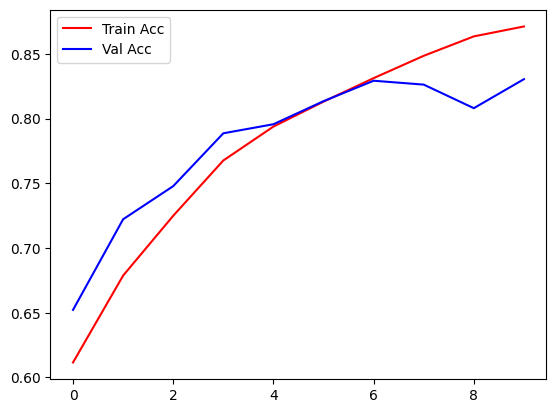

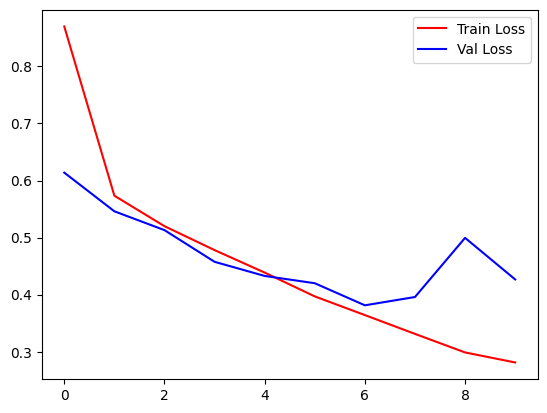

Prediction (1=dog, 0=cat): False


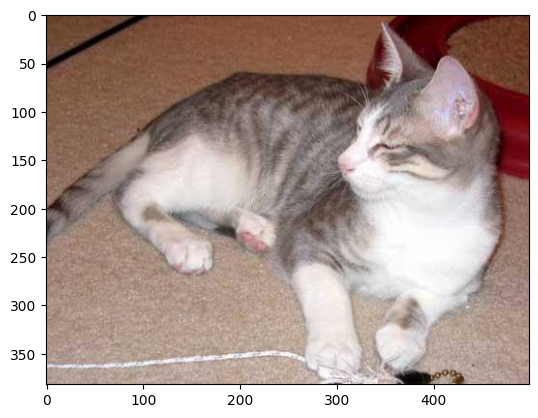

In [3]:
# Step 1: Download and extract dataset using Kaggle CLI
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d salader/dogs-vs-cats

import zipfile
with zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

# Step 2: Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

# Step 3: Transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Step 4: Datasets and Dataloaders
train_data = datasets.ImageFolder('/content/train', transform=transform)
val_data = datasets.ImageFolder('/content/test', transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

# Step 5: Define CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 30 * 30, 128)
        self.drop1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.drop1(F.relu(self.fc1(x)))
        x = self.drop2(F.relu(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))
        return x

# Step 6: Instantiate model, define loss and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 7: Training Loop
train_acc, val_acc, train_loss, val_loss = [], [], [], []

for epoch in range(10):
    model.train()
    correct, total, running_loss = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item()

    train_acc.append(correct / total)
    train_loss.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    correct, total, running_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item()

    val_acc.append(correct / total)
    val_loss.append(running_loss / len(val_loader))

    print(f"Epoch {epoch+1}: Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

# Step 8: Plotting accuracy and loss
plt.plot(train_acc, 'r', label='Train Acc')
plt.plot(val_acc, 'b', label='Val Acc')
plt.legend()
plt.show()

plt.plot(train_loss, 'r', label='Train Loss')
plt.plot(val_loss, 'b', label='Val Loss')
plt.legend()
plt.show()

# Step 9: Predicting on new image
img = cv2.imread('/content/cat.66.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img = cv2.resize(img, (256, 256))
img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img_tensor = transform(img).unsqueeze(0).to(device)
output = model(img_tensor)
print("Prediction (1=dog, 0=cat):", (output.item() > 0.5))
